<a href="https://colab.research.google.com/github/preetpalsinghspat/Language-Models-Named-Entity-Recognition-/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Team
Preetpal singh, Rampuneet kumar

## Aim:
### __Named Entity Recognition on astrophysics papers__

Locate and tag astronomical entities in astrophysics papers.

## Introduction:<br>
**Named Entity Recognition** is an information extraction technique used to locate and classify named entities in unstructured text 
into predifined categories such as names, organizations, locations, numerical values , date etc.<br>

Here `NER`  is done to find and tag astronomical entities such as Celestial bodies, Event, Formula and other in astrophysics papers.<br>

The dataset tagging is done on **IOB format** (Inside‚Äìoutside‚Äìbeginning).

A problem by [**Workshop on Information Extraction from Scientific Publications**](https://ui.adsabs.harvard.edu/WIESP/)




## Imports

In [39]:
import pandas as pd 
import numpy as np 
import json 
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Input, TimeDistributed, Dense, Embedding,dot,Reshape,Bidirectional
from numpy.linalg import norm

In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import sequence
from tensorflow.keras.models import Model, Sequential 

In [3]:
!gdown --folder https://drive.google.com/drive/folders/1sbzrKzg5l4sfF1tR1MZH3EOhBZiCylO7?usp=sharing 

Retrieving folder list
Processing file 18hViGRsF93C7P9849PhAG_APjxhZJ-GQ WIESP2022-NER-TRAINING.jsonl
Processing file 1rbPFEt_vs5fbqsE6-9wOrfKFhLx7h7JU WIESP2022-NER-VALIDATION-NO-LABELS.jsonl
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=18hViGRsF93C7P9849PhAG_APjxhZJ-GQ
To: /content/WIE/WIESP2022-NER-TRAINING.jsonl
100% 9.95M/9.95M [00:00<00:00, 60.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rbPFEt_vs5fbqsE6-9wOrfKFhLx7h7JU
To: /content/WIE/WIESP2022-NER-VALIDATION-NO-LABELS.jsonl
100% 3.81M/3.81M [00:00<00:00, 88.2MB/s]
Download completed


### **DATASET**

Name: WIESP2022-NER<br>
Link: https://huggingface.co/datasets/fgrezes/WIESP2022-NER

__Description__:<br>
Dataset contains separate json files for Training and Validation . Made available by [NASA Astrophysical Data System](https://ui.adsabs.harvard.edu/). with manually tagged astronomical facilities and other entities of interest. <br/>
__Contains__:<br>
  "unique_id": a unique identifier for this data sample.<br> 
  "tokens": the list of tokens (strings) that form the text of this sample.<br>
  "ner_tags": the list of NER tags

### Pre-Processing

In this step we will load the json files then covert them to dataframes. Using TensorFlow tokenizer for each sentence we will tokenize and add to the dataframe.


In [4]:
file_path = '/content/WIE/WIESP2022-NER-TRAINING.jsonl'
file_path_val = '/content/WIE/WIESP2022-NER-VALIDATION-NO-LABELS.jsonl'

In [5]:
# read the json files
with open(file_path,'r') as f:
  data = [json.loads(a) for a in list(f)]

with open(file_path_val,'r') as f:
  data_val = [json.loads(a) for a in list(f)]

In [6]:
# create dataframe
df_train=pd.DataFrame(data)
df_val = pd.DataFrame(data_val)

In [7]:
# a look at training df
df_train.head()

bibcode  label_studio_id  \
0  2019MNRAS.486.5558S              487   
1  2018MNRAS.478.5533F             1129   
2  2018MNRAS.480.3062L             1086   
3  2016MNRAS.457.1786M             1135   
4  2019MNRAS.482L...9B              559   

                                             ner_ids  \
0  [62, 62, 62, 62, 62, 62, 62, 15, 62, 62, 62, 6...   
1  [62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...   
2  [62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...   
3  [22, 62, 62, 62, 62, 21, 13, 44, 44, 21, 62, 1...   
4  [62, 62, 62, 22, 53, 22, 53, 22, 53, 22, 53, 2...   

                                            ner_tags          section  \
0  [O, O, O, O, O, O, O, B-Instrument, O, O, O, O...         fulltext   
1  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...         fulltext   
2  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...  acknowledgments   
3  [B-Person, O, O, O, O, B-Organization, B-Grant...  acknowledgments   
4  [O, O, O, B-Person, I-Person, B-Person, I-Pers...  acknowledgments   

                                              tokens  \
0  [Whilst, a, reasonable, harmonic, fit, to, the...   
1  [comparison, once, the, angular, positions, of...   
2  [ACKNOWLEDGEMENTS, The, authors, thank, an, an...   
3  [BDM, gratefully, acknowledges, support, from,...   
4  [ACKNOWLEDGEMENTS, We, thank, Dougal, Mackey,,...   

                                  unique_id  
0          fulltext_487_2019MNRAS.486.5558S  
1         fulltext_1129_2018MNRAS.478.5533F  
2  acknowledgments_1086_2018MNRAS.480.3062L  
3  acknowledgments_1135_2016MNRAS.457.1786M  
4   acknowledgments_559_2019MNRAS.482L...9B

In [8]:
# tags a map of ner tag to ner ids
tags = '{"B-Archive": 0, "B-CelestialObject": 1, "B-CelestialObjectRegion": 2, "B-CelestialRegion": 3, "B-Citation": 4, "B-Collaboration": 5, "B-ComputingFacility": 6, "B-Database": 7, "B-Dataset": 8, "B-EntityOfFutureInterest": 9, "B-Event": 10, "B-Fellowship": 11, "B-Formula": 12, "B-Grant": 13, "B-Identifier": 14, "B-Instrument": 15, "B-Location": 16, "B-Mission": 17, "B-Model": 18, "B-ObservationalTechniques": 19, "B-Observatory": 20, "B-Organization": 21, "B-Person": 22, "B-Proposal": 23, "B-Software": 24, "B-Survey": 25, "B-Tag": 26, "B-Telescope": 27, "B-TextGarbage": 28, "B-URL": 29, "B-Wavelength": 30, "I-Archive": 31, "I-CelestialObject": 32, "I-CelestialObjectRegion": 33, "I-CelestialRegion": 34, "I-Citation": 35, "I-Collaboration": 36, "I-ComputingFacility": 37, "I-Database": 38, "I-Dataset": 39, "I-EntityOfFutureInterest": 40, "I-Event": 41, "I-Fellowship": 42, "I-Formula": 43, "I-Grant": 44, "I-Identifier": 45, "I-Instrument": 46, "I-Location": 47, "I-Mission": 48, "I-Model": 49, "I-ObservationalTechniques": 50, "I-Observatory": 51, "I-Organization": 52, "I-Person": 53, "I-Proposal": 54, "I-Software": 55, "I-Survey": 56, "I-Tag": 57, "I-Telescope": 58, "I-TextGarbage": 59, "I-URL": 60, "I-Wavelength": 61, "O": 62}'
tags = eval(tags)
n_tags = len(tags)
print("total no of tags are: ", n_tags)

total no of tags are:  63


In [9]:
# instanciate tokenizer filters are removed to avoid removing formulas
tokenizer=tf.keras.preprocessing.text.Tokenizer(filters='',lower=True)
# fit on training sentences
tokenizer.fit_on_texts(df_train['tokens'])

In [10]:
def tokenize(text):
  '''
  This function uses tokenizer and convert text to sequences as each token is a 
  list of its own get the element an add it to token, return token which are the
  tokens corresponding to the input sentence
  '''
  token=[]
  tk=tokenizer.texts_to_sequences(text)
  for i in tk: 
    token.append(i[0])
  
  return token

In [11]:
np.array(df_val['tokens']).shape, np.array(df_train['tokens']).shape

((1366,), (1753,))

In [12]:
tk=tokenizer.texts_to_sequences(df_val['tokens'])
len(tk)

1366

In [13]:
# apply tokenize funtion to both dataframes
df_train['token_no']=df_train['tokens'].apply(lambda x:tokenize(x))
df_val['token_no']=tokenize(df_val['tokens'])

In [14]:
# save tokenizer and the two dataframes for easy reuse
joblib.dump(tokenizer,'tokenizer.pkl')
joblib.dump(df_train,'df_train.pkl')
joblib.dump(df_val,'df_val.pkl')

['df_val.pkl']

## Performing EDA to get insights from the data

In [15]:
# calculating most frequent tags
no_top_tags=20
tag_dict={k:0 for k in tags.keys()}
top_tags={}
for entry in df_train['ner_tags']:
  for i in entry:
    tag_dict[i]+=1
for k,v in sorted(tag_dict.items(), key=lambda kv: kv[1],reverse=True)[1:no_top_tags+1]:
  top_tags[k]=v

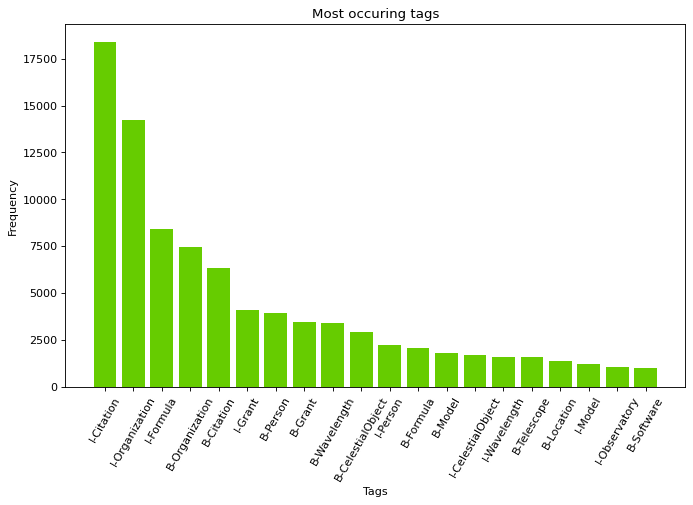

In [16]:
# plotting most occuring tags
plt.figure(figsize=(10, 6), dpi=80)
plt.title('Most occuring tags')
plt.bar(top_tags.keys(),top_tags.values(),color='#66cc00')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.xticks(rotation = 60)
plt.show()

The most occuring tag was the 'O' tag we have to remove it beacuse it was very high in distribution, maing it harder to visualise the distribution of other ner tags

In [17]:
sentence_len=[len(entry) for entry in df_train['tokens']]

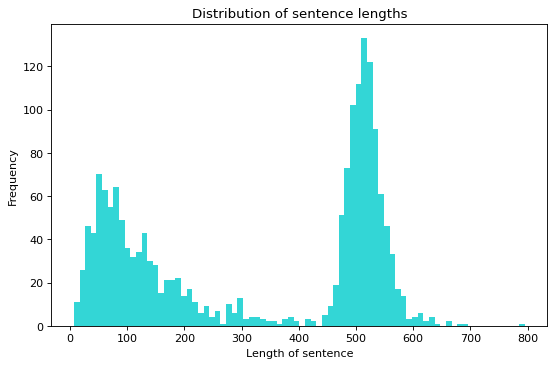

In [18]:
plt.figure(figsize=(8, 5), dpi=80)
plt.hist(sentence_len,bins=80,alpha=0.8,color='#00cccc')
plt.title('Distribution of sentence lengths')
plt.xlabel('Length of sentence')
plt.ylabel('Frequency')
plt.show()

## Data Pipelining

In [19]:
X_train = df_train['token_no'].values
y_train = df_train['ner_ids'].values

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=0)

In [21]:
max_len = max([len(sent) for sent in X_train])
print(f"maximum length of a sentance is: {max_len}")

maximum length of a sentnce is: 795


In [22]:
X_train = pad_sequences(
    X_train,
    padding='post',
    value=0.0)

X_val = pad_sequences(
    X_val,
    maxlen=max_len,
    padding='post',
    value=0.0)

In [23]:
# paddding with the index of the tag 'O'
y_train = pad_sequences(
    y_train,
    padding='post',
    value = tags['O'])

y_val = pad_sequences(
    y_val,
    maxlen=max_len,
    padding='post',
    value = tags['O'])

In [24]:
y_train = [to_categorical(sent, n_tags) for sent in y_train]
y_val = [to_categorical(sent, n_tags) for sent in y_val]

In [25]:
batch_size = 64
train_shuffle_buffer_size = len(X_train)
test_shuffle_buffer_size = len(X_val)

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(AUTOTUNE)

val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_data = val_data.shuffle(buffer_size=test_shuffle_buffer_size)
val_data = val_data.batch(batch_size)
val_data = val_data.prefetch(AUTOTUNE)

In [26]:
vocabulary = len(tokenizer.index_word.keys())
print(f"Total vobcabulary size is (inluding UNK): {vocabulary + 1}")

Total vobcabulary size is (inluding UNK): 45754


# Modelling the data
After preprocesiing the datset now it's time for modelling the data, to get good model for named entity recognition problem

## 1. Vanilla 2 stack LSTM

This model comprises of:

1) An embedding layer, with the embedding size set to 128 and vocabulary equal to 45754.

2) after that there are two LSTM layers stacked on top of each other, in the last layer we have also set the return sequences to True, because of time distributed layer to get many to many outputs

3) The last layer TimeDistrbutedLayer, which is applied on a dense layer with relu activation, this layers gives output word by word for a sequence rather then giving one single output at the end of a sequence. As we are trying to solve a many to many problem because each word will be having one tag out of 67 associated with it in a sequence.

In [209]:
inputs = Input(max_len)
x = Embedding(vocabulary + 1, 128, mask_zero=True)(inputs)
x = LSTM(100, return_sequences=True)(x)
x = LSTM(100, return_sequences=True)(x)
outputs = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 795)]             0         
                                                                 
 embedding (Embedding)       (None, 795, 128)          5856512   
                                                                 
 lstm (LSTM)                 (None, 795, 100)          91600     
                                                                 
 lstm_1 (LSTM)               (None, 795, 100)          80400     
                                                                 
 time_distributed (TimeDistr  (None, 795, 63)          6363      
 ibuted)                                                         
                                                                 
Total params: 6,034,875
Trainable params: 6,034,875
Non-trainable params: 0
___________________________________________________

In [215]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=8, restore_best_weights=True, verbose=1)
history = model.fit(train_data, validation_data=val_data, epochs=50, callbacks=es)

Epoch 1/50
22/22 [==============================] - 14s 232ms/step - loss: 0.4371 - accuracy: 0.8247 - val_loss: 0.4140 - val_accuracy: 0.8214
Epoch 2/50
22/22 [==============================] - 2s 95ms/step - loss: 0.4221 - accuracy: 0.8247 - val_loss: 0.4067 - val_accuracy: 0.8214
Epoch 3/50
22/22 [==============================] - 2s 96ms/step - loss: 0.4156 - accuracy: 0.8247 - val_loss: 0.3980 - val_accuracy: 0.8214
Epoch 4/50
22/22 [==============================] - 2s 95ms/step - loss: 0.3966 - accuracy: 0.8242 - val_loss: 0.3656 - val_accuracy: 0.8212
Epoch 5/50
22/22 [==============================] - 2s 95ms/step - loss: 0.3474 - accuracy: 0.8242 - val_loss: 0.3135 - val_accuracy: 0.8260
Epoch 6/50
22/22 [==============================] - 2s 96ms/step - loss: 0.3011 - accuracy: 0.8423 - val_loss: 0.2866 - val_accuracy: 0.8428
Epoch 7/50
22/22 [==============================] - 2s 97ms/step - loss: 0.2750 - accuracy: 0.8480 - val_loss: 0.2710 - val_accuracy: 0.8443
Epoch 8/50


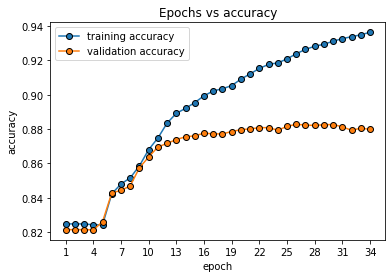

In [216]:
n_epochs = len(history.history['accuracy'])
plt.plot(range(1, n_epochs + 1), history.history['accuracy'],  marker = 'o', markeredgecolor='k', label='training accuracy')
plt.plot(range(1, n_epochs + 1), history.history['val_accuracy'],  marker = 'o', markeredgecolor='k', label='validation accuracy')
plt.legend(loc='best')
plt.xticks(range(1, n_epochs+1, 3))
plt.title("Epochs vs accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

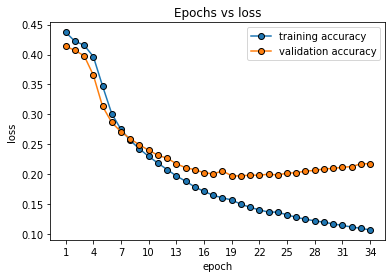

In [217]:
plt.plot(range(1, n_epochs + 1), history.history['loss'],  marker = 'o', markeredgecolor='k', label='training accuracy')
plt.plot(range(1, n_epochs + 1), history.history['val_loss'],  marker = 'o', markeredgecolor='k', label='validation accuracy')
plt.legend(loc='best')
plt.xticks(range(1, n_epochs+1, 3))
plt.title("Epochs vs loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [218]:
loss1, accuracy1 = model.evaluate(val_data)
print(f"\n\nModel with 2 stack vanilla lst model is giving: \naccuracy: {accuracy1:.3f}\nloss: {loss1:.3f}")

6/6 [==============================] - 0s 40ms/step - loss: 0.2026 - accuracy: 0.8828


Model with 2 stack vanilla lst model is giving: 
accuracy: 0.883
loss: 0.203


In [220]:
#making one sample from validatoin_data
x, y = next(iter(val_data.take(1)))
sample_x, sample_true_y = x[0], y[0]
print(f"Size of 1 sample from validation data is (x and y): {sample_x.shape, sample_true_y.shape}")

Size of 1 sample from validation data is (x and y): (TensorShape([795]), TensorShape([795, 63]))


In [221]:
#‚ö†Ô∏èdependency on tokenizer created above, and tags dictionary
def print_senttags(sample_X, sample_true_y):
  '''
  args:
    sample_x: tokenized sentance
    sample_true_y: one hot encoded or softmaxed ner tags (shoul be of shape [len(sample_x), 63]) 
  '''
  print("sample token to word(padded tokens are skipped) with there corresponding tag (except for 'O' tag): \n\n")
  reverse_tags = {id_:tag for tag, id_ in tags.items()}
  sentance = tokenizer.sequences_to_texts([sample_x.numpy()])[0].split()
  ner_tags = [np.argmax(vec) for vec in sample_true_y][:len(sentance)]
  assert len(ner_tags) == len(sentance)
  sentances_with_tag = ' '.join([sent if tag_id == 62 else f'{sent}[{reverse_tags[tag_id]}]' for sent, tag_id in zip(sentance, ner_tags)])
  return sentances_with_tag

In [222]:
pred_y = model.predict(np.expand_dims(sample_x, 0))[0]

In [223]:
sample_true_y.shape

TensorShape([795, 63])

In [224]:
#actual ner tags
print_senttags(sample_x, sample_true_y)

sample token to word(padded tokens are skipped) with there corresponding tag (except for 'O' tag): 




'( 16 ), the br emissivity in the classical limit then reads where p min is the minimal electron momentum that is required to produce a photon of energy œâ[B-Formula] =[I-Formula] h[I-Formula] ŒΩ/[I-Formula] m[I-Formula] e[I-Formula] c[I-Formula] 2[I-Formula] . this is determined by œâ[B-Formula] =[I-Formula] Œ≥[I-Formula] min[I-Formula] ‚àí[I-Formula] 1,[I-Formula] which yields . in the last step of equation ( 17 ), we used a non-relativistic[B-Model] maxwell‚Äìboltzmann[I-Model] distribution[I-Model] function,[I-Model] with dimensionless electron temperature Œ∏[B-Formula] e[I-Formula] =[I-Formula] kt[I-Formula] e[I-Formula] /[I-Formula] m[I-Formula] e[I-Formula] c[I-Formula] 2[I-Formula] to carry out the integral. the above expressions explicitly assume p[B-Formula] 1[I-Formula] ,[I-Formula] œâ[I-Formula] ‚â™[I-Formula] 1.[I-Formula] even without quantum corrections, to generalize the kramers[B-Model] approximation[I-Model] to higher temperatures/energies, we shall use the relativist

In [225]:
print_senttags(sample_x, pred_y)

sample token to word(padded tokens are skipped) with there corresponding tag (except for 'O' tag): 




'( 16 ), the br emissivity in the classical limit then reads where p min is the minimal electron momentum that is required to produce a photon of energy œâ = h ŒΩ/ m e c 2 . this is determined by œâ = Œ≥[I-Formula] min[I-Formula] ‚àí 1, which yields . in the last step of equation ( 17 ), we used a non-relativistic maxwell‚Äìboltzmann distribution function, with dimensionless electron temperature Œ∏ e[I-Formula] =[I-Formula] kt[I-Formula] e[I-Formula] /[I-Formula] m[I-Formula] e[I-Formula] c[I-Formula] 2[I-Formula] to carry out the integral. the above expressions explicitly assume p 1 , œâ ‚â™[I-Formula] 1.[I-Formula] even without quantum corrections, to generalize the kramers approximation to higher temperatures/energies,[I-Formula] we shall use the relativistic maxwell‚Äìboltzmann distribution function where k 2 ( x[I-Formula] ) is the modified bessel function of second kind. 9 we also keep the full relativistic expression for and furthermore realize that at low frequencies the overal

We can see that the model is giving good accuracy and better prediction of ner tags (enclosed inside [] brackets), but we can perform better by using models which can perform much better then this below.



## 2. lstm and bidirectional lstm stacked model with word 2 vec embeddings.

### 2.1 training our own Word2vec moel to get embeddings

In [65]:
continous_data =[]
for i in df_train['token_no'].values:
  continous_data+=i

In [66]:
sampling_table=sequence.make_sampling_table(vocabulary+1)
couples,labels=sequence.skipgrams(continous_data,vocabulary+1,window_size=3,sampling_table=sampling_table,seed=43)
del continous_data

In [67]:
words,context=zip(*couples)
words=np.array(words)
context=np.array(context)
labels=np.array(labels)

In [69]:
emb_size=128

Our mode architecture inlcudes:

1) one embedding layer, whose trained weights will be used for our bidirecinal lstm model

2) one more embedding layer(context embeddings) these are used to find the word embeddings efficiently, as embedding of a context word with the output of above layer should have dot product close to 0

3) at the end we have a dot product layer, to compute dot product between embedding from word and contexts embeddings

In [70]:
word_model = Sequential() 
word_model.add(Embedding(vocabulary+1, emb_size, input_length=1,name='Embedding')) 
word_model.add(Reshape((emb_size, )))

context_model = Sequential() 
context_model.add(Embedding(vocabulary+1, emb_size, input_length=1,name='Context')) 
context_model.add(Reshape((emb_size,))) 

dot_product = dot([word_model.output, context_model.output], axes=1,normalize=False,name='dotproduct_layer') 

output = Dense(1,activation="sigmoid",name='Output')(dot_product)

model_w2v = Model(inputs=[word_model.input, context_model.input], outputs=output,name='word2vec') 

model_w2v.summary()

Model: "word2vec"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Embedding_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Context_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 Embedding (Embedding)          (None, 1, 128)       5856512     ['Embedding_input[0][0]']        
                                                                                                  
 Context (Embedding)            (None, 1, 128)       5856512     ['Context_input[0][0]']          
                                                                                           

In [74]:
model_w2v.compile(loss="binary_crossentropy", optimizer="rmsprop",metrics=['accuracy'])
print(f"total number of observations are: {len(words)}")

total number of observations are: 1704172


In [75]:
history_w2v=model_w2v.fit(x=[words,context],y=labels,validation_split=0.2,epochs=20,batch_size=512,verbose=1)

Epoch 1/20
2663/2663 [==============================] - 12s 4ms/step - loss: 0.5756 - accuracy: 0.6972 - val_loss: 0.4205 - val_accuracy: 0.8173
Epoch 2/20
2663/2663 [==============================] - 11s 4ms/step - loss: 0.3767 - accuracy: 0.8549 - val_loss: 0.3934 - val_accuracy: 0.8586
Epoch 3/20
2663/2663 [==============================] - 11s 4ms/step - loss: 0.3548 - accuracy: 0.8649 - val_loss: 0.3741 - val_accuracy: 0.8543
Epoch 4/20
2663/2663 [==============================] - 12s 4ms/step - loss: 0.3511 - accuracy: 0.8623 - val_loss: 0.3748 - val_accuracy: 0.8553
Epoch 5/20
2663/2663 [==============================] - 11s 4ms/step - loss: 0.3517 - accuracy: 0.8617 - val_loss: 0.3739 - val_accuracy: 0.8539
Epoch 6/20
2663/2663 [==============================] - 11s 4ms/step - loss: 0.3522 - accuracy: 0.8614 - val_loss: 0.3741 - val_accuracy: 0.8540
Epoch 7/20
2663/2663 [==============================] - 13s 5ms/step - loss: 0.3524 - accuracy: 0.8613 - val_loss: 0.3745 - val_ac

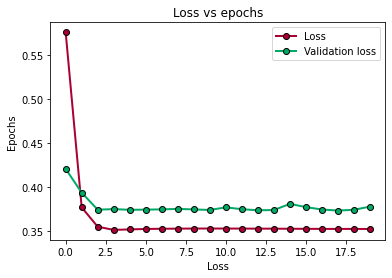

In [78]:
plt.plot(history_w2v.history['loss'],c='#aa0033',marker = 'o', markeredgecolor='k',linewidth=2,label='Loss')
plt.plot(history_w2v.history['val_loss'],c='#00aa66',marker = 'o', markeredgecolor='k',linewidth=2,label='Validation loss')
plt.title('Loss vs epochs')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

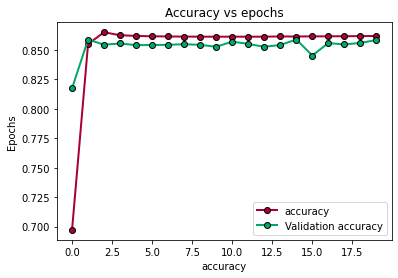

In [79]:
plt.plot(history_w2v.history['accuracy'],c='#aa0033',marker = 'o', markeredgecolor='k',linewidth=2,label='accuracy')
plt.plot(history_w2v.history['val_accuracy'],c='#00aa66',marker = 'o', markeredgecolor='k',linewidth=2,label='Validation accuracy')
plt.title('Accuracy vs epochs')
plt.xlabel('accuracy')
plt.ylabel('Epochs')
plt.legend()
plt.show()

Checking how good the embeddings actually are, with the help of cosine similarity

In [42]:
def cosine_similarity(vectorA, vectorB):
    return np.dot(vectorA, vectorB)/(norm(vectorA)*norm(vectorB))

In [47]:
def most_similar(word:str, n:int, embeddings: np.ndarray) -> list:
  '''Takes in a word and returns the top n words having highest cosine similarity in there embeddings
  predicted by model.'''
  similarity = dict()
  for key, embedding in embeddings.items():
    similarity[key] = cosine_similarity(embeddings[word.lower()], embedding)
  return sorted(similarity.items(), key = lambda x: x[1], reverse=True)[:n]

In [80]:
reverse_dictionary = tokenizer.index_word
pred = word_model.predict(list(reverse_dictionary.keys()))
embeddings = dict(zip(reverse_dictionary.values(), pred))

In [90]:
len(reverse_dictionary.keys())

45753

In [93]:
print("top 10 words similar to word 'state' are: ")
most_similar('state', 10, embeddings)

top 10 words similar to word 'state' are: 


[('state', 1.0),
 ('ohio', 0.99678475),
 ('york', 0.99573624),
 ('pennsylvania', 0.99543315),
 ('portsmouth,', 0.99523634),
 ('university,', 0.9949469),
 ('penn', 0.994803),
 ('nottingham,', 0.99466497),
 ('chicago,', 0.9944144),
 ('participating', 0.99425095)]

We can see here that some embeddings have sementic meaning, the possble cause of some inconsistency in results could be because we are concatinating every sequence into one giant sequence. so that we can make use of make sampliing table. Which also leads to an issue because the last word in a sentance and the next word in another sentance of our problem dosen't have semantic meaning.

that is a sacrifice we are willing to make.

Training our word 2 vec model on full data, as we are satsified with the results

In [100]:
word_model = Sequential()
word_model.add(Embedding(vocabulary+1, emb_size, input_length=1,name='Embedding')) 
word_model.add(Reshape((emb_size, )))

context_model = Sequential() 
context_model.add(Embedding(vocabulary+1, emb_size, input_length=1,name='Context')) 
context_model.add(Reshape((emb_size,))) 

dot_product = dot([word_model.output, context_model.output], axes=1,normalize=False,name='dotproduct_layer') 

output = Dense(1,activation="sigmoid",name='Output')(dot_product)

model_w2v = Model(inputs=[word_model.input, context_model.input], outputs=output,name='word2vec') 

model_w2v.summary()

Model: "word2vec"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Embedding_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Context_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 Embedding (Embedding)          (None, 1, 128)       5856512     ['Embedding_input[0][0]']        
                                                                                                  
 Context (Embedding)            (None, 1, 128)       5856512     ['Context_input[0][0]']          
                                                                                           

In [103]:
#training on full data
es = tf.keras.callbacks.EarlyStopping(patience=5, mode='max', monitor='accuracy')
model_w2v.compile(loss="binary_crossentropy", optimizer="rmsprop",metrics=['accuracy'])
history_w2v=model_w2v.fit(x=[words,context],y=labels, epochs=20,batch_size=512,verbose=1, callbacks=es)

Epoch 1/20
3329/3329 [==============================] - 28s 8ms/step - loss: 0.5302 - accuracy: 0.7349
Epoch 2/20
3329/3329 [==============================] - 28s 8ms/step - loss: 0.3725 - accuracy: 0.8647
Epoch 3/20
3329/3329 [==============================] - 28s 9ms/step - loss: 0.3519 - accuracy: 0.8635
Epoch 4/20
3329/3329 [==============================] - 19s 6ms/step - loss: 0.3532 - accuracy: 0.8616
Epoch 5/20
3329/3329 [==============================] - 19s 6ms/step - loss: 0.3543 - accuracy: 0.8609
Epoch 6/20
3329/3329 [==============================] - 22s 7ms/step - loss: 0.3548 - accuracy: 0.8606
Epoch 7/20
3329/3329 [==============================] - 23s 7ms/step - loss: 0.3550 - accuracy: 0.8603


In [104]:
embedding_weights = model_w2v.get_layer('Embedding').get_weights()[0]
embedding_weights.shape

(45754, 128)

In [106]:
joblib.dump(embeddings,'word2vec_embeddings.pkl')

['word2vec_embeddings.pkl']

### 2.2 training our bidirectional lstm model with word 2 vec embeddings

the model architecture includes:

1) embedding layer of shape (vocab_size + 1, 128)

2) LSTM layer with 100 units, and return sequences set to true so it could be passed to stacked bidirectional lstm layer

3) Bidirectinal LSTM layers

4) Timedistributedlayer for many to many ouputs, whih is wrapped on a dense layer with activation set to softmax

In [159]:
inputs = Input(max_len)
emb = Embedding(vocabulary + 1, emb_size, mask_zero=True,name='w2vembedding')(inputs)
lstm_1 = LSTM(128, return_sequences=True)(emb)
lstm_2 = Bidirectional(LSTM(128, return_sequences=True))(lstm_1)
lstm_3 = Bidirectional(LSTM(256, return_sequences=True))(lstm_2)
outputs = TimeDistributed(Dense(n_tags, activation="softmax"))(lstm_3)
model2 = tf.keras.Model(inputs, outputs)
model2.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 795)]             0         
                                                                 
 w2vembedding (Embedding)    (None, 795, 128)          5856512   
                                                                 
 lstm_25 (LSTM)              (None, 795, 128)          131584    
                                                                 
 bidirectional_15 (Bidirecti  (None, 795, 256)         263168    
 onal)                                                           
                                                                 
 bidirectional_16 (Bidirecti  (None, 795, 512)         1050624   
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 795, 63)          323

In [160]:
#setting weights to the word 2 vec embeddings
model2.get_layer('w2vembedding').set_weights([embedding_weights])
model2.get_layer('w2vembedding').trainable=False

In [161]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True, verbose=1)
history2 = model2.fit(train_data, validation_data=val_data, epochs=100, callbacks=es)

Epoch 1/100
22/22 [==============================] - 36s 599ms/step - loss: 0.5390 - accuracy: 0.7824 - val_loss: 0.4098 - val_accuracy: 0.8214
Epoch 2/100
22/22 [==============================] - 6s 262ms/step - loss: 0.4189 - accuracy: 0.8247 - val_loss: 0.4033 - val_accuracy: 0.8214
Epoch 3/100
22/22 [==============================] - 6s 263ms/step - loss: 0.4136 - accuracy: 0.8247 - val_loss: 0.3973 - val_accuracy: 0.8214
Epoch 4/100
22/22 [==============================] - 6s 264ms/step - loss: 0.3931 - accuracy: 0.8244 - val_loss: 0.3590 - val_accuracy: 0.8235
Epoch 5/100
22/22 [==============================] - 6s 264ms/step - loss: 0.3623 - accuracy: 0.8295 - val_loss: 0.3379 - val_accuracy: 0.8341
Epoch 6/100
22/22 [==============================] - 6s 264ms/step - loss: 0.3423 - accuracy: 0.8426 - val_loss: 0.3225 - val_accuracy: 0.8443
Epoch 7/100
22/22 [==============================] - 6s 264ms/step - loss: 0.3293 - accuracy: 0.8483 - val_loss: 0.3093 - val_accuracy: 0.845

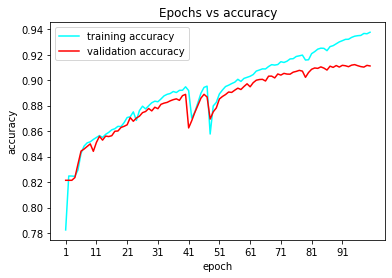

In [167]:
n_epochs = len(history2.history['accuracy'])
plt.plot(range(1, n_epochs + 1), history2.history['accuracy'],color='cyan', label='training accuracy')
plt.plot(range(1, n_epochs + 1), history2.history['val_accuracy'],color='red', label='validation accuracy')
plt.legend(loc='best')
plt.xticks(range(1, n_epochs+1, 10))
plt.title("Epochs vs accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

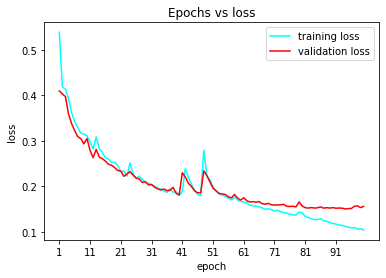

In [168]:
plt.plot(range(1, n_epochs + 1), history2.history['loss'],color='cyan', label='training loss')
plt.plot(range(1, n_epochs + 1), history2.history['val_loss'],color='red', label='validation loss')
plt.legend(loc='best')
plt.xticks(range(1, n_epochs+1, 10))
plt.title("Epochs vs loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [208]:
loss2, accuracy2 = model2.evaluate(val_data)
print(f"\n\nModel with bidirectional lstm and lstm model is giving: \naccuracy: {accuracy2:.3f}\nloss: {loss2:.3f}")

6/6 [==============================] - 5s 105ms/step - loss: 0.1557 - accuracy: 0.9112


Model with bidirectional lstm and lstm model is giving: 
accuracy: 0.911
loss: 0.156


In [174]:
#making one sample from validatoin_data
x, y = next(iter(val_data.take(1)))
sample_x, sample_true_y = x[0], y[0]
print(f"Size of 1 sample from validation data is (x and y): {sample_x.shape, sample_true_y.shape}")

Size of 1 sample from validation data is (x and y): (TensorShape([795]), TensorShape([795, 63]))


In [175]:
pred_y = model2.predict(np.expand_dims(sample_x, 0))[0]

In [176]:
print_senttags(sample_x, sample_true_y)

sample token to word(padded tokens are skipped) with there corresponding tag (except for 'O' tag): 




'that the 3:2 mmr of the orbital periods affect periodic variations of the keplerian[B-Model] orbital parameters. she has obtained the expansion of disturbing function and identified only two first-order 3:2 resonance term. but we identify ( r + 1): r mmr terms in the expression of disturbing function and obtained the perturbations from the truncated disturbing function. in this manuscript, we have taken three exoplanetary systems namely kepler-62,[B-CelestialObject] hd[B-CelestialObject] 200964[I-CelestialObject] and kepler-11[B-CelestialObject] and as per our knowledge they contain planets in 2:1, 4:3 and 5:4 near mmrs, respectively. we apply theory discussed in sections 3 and 4 individually in our three exoplanetary systems that we have chosen. this paper is organized as follows. in section 2, we introduce the general three-body problem and the stability of exoplanetary system. the expansions of the disturbing function and perturbation equations of orbital elements are introduced in

In [150]:
print_senttags(sample_x, pred_y)

sample token to word(padded tokens are skipped) with there corresponding tag (except for 'O' tag): 




'the authors are indebted to jeff coughlin for his expert review and suggestion to use the kepler ffis to evaluate false positive scenarios. e.g. was supported by the international short visit program of the swiss national science foundation. this paper includes data collected by the kepler mission, funding for which is provided by the nasa science mission directorate. some of the data presented herein were obtained at the w. m. keck observatory, which is operated as a scientific partnership among the california institute of technology, the university of california and nasa. the observatory was made possible by the generous financial support of the w.m. keck foundation. this research has made use of the nasa exoplanet archive, which is operated by the california institute of technology, under contract with the national aeronautics[I-Organization] and[I-Organization] space[I-Organization] administration[I-Organization] under the exoplanet exploration program. this research has also made

We can see above that our model is now able to find out a good amount of ner tags with very good accuracy

## 3. Transformers is all you need! üôå
in this part we will be using a transformer to predict ner tags.

In [179]:
def generate_positional_encoding(max_length, model_size):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / model_size) for j in range(model_size)]
            if pos != 0
            else np.zeros(model_size)
            for pos in range(max_length)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

In [180]:
# defining our encoder layer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads):
        super().__init__()
        # Layer parameters
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # MultiHeadAttention Layer - Self Attention
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Normalization Layer
        self.attention_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # Dense projection
        self.dense_proj = tf.keras.Sequential(
            [tf.keras.layers.Dense(units=dense_dim, activation="relu"),
             tf.keras.layers.Dense(units=embed_dim)]
        )
        # Normalization Layer
        self.dense_projection_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        
        # Compute Self Attention
        self_attention = self.attention(query=inputs, value=inputs, key=inputs)
        # Apply Normalization + Residual connection
        self_attention = self.attention_norm(inputs + self_attention)

        # Apply projection
        layer_output = self.dense_proj(self_attention)
        # Apply Normalization + Residual connection
        layer_output = self.dense_projection_norm(self_attention + layer_output)

        return layer_output

In [181]:
# Generate postional encodings for sequence length of 60 and embedding dimension of 256
positional_encodings = generate_positional_encoding(60, 256)
print(positional_encodings.shape)

print("Position 0:",positional_encodings[0][:20])
print("Position 1:",positional_encodings[1][:20])
print("Position 2:",positional_encodings[2][:20])

(60, 256)
Position 0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Position 1: [0.84147098 0.54030231 0.8019618  0.59737533 0.76172041 0.64790587
 0.72141412 0.69250391 0.68156135 0.73176098 0.64255691 0.76623796
 0.60469402 0.79645787 0.56818322 0.82290208 0.53316844 0.84600911
 0.49974046 0.8661752 ]
Position 2: [ 0.90929743 -0.41614684  0.95814438 -0.28628544  0.98704625 -0.16043596
  0.9991642  -0.04087666  0.99748     0.07094825  0.984703    0.17424123
  0.96322662  0.26869029  0.9351183   0.35433567  0.90213071  0.43146283
  0.86572559  0.50051894]


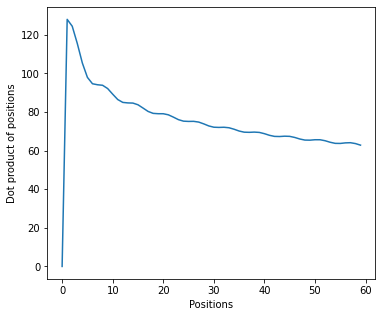

In [182]:
# Compute the dot product of postion 1 with every other postions
dot_results = []
for idx in range(positional_encodings.shape[0]):
  dot_results.append(np.dot(positional_encodings[1], positional_encodings[idx]))


# Plot the dot product results
fig = plt.figure(figsize=(20,5))
axs = fig.add_subplot(1,3,1)
axs.plot(np.arange(0, positional_encodings.shape[0]), dot_results)
axs.set_xlabel('Positions')
axs.set_ylabel('Dot product of positions')
plt.show()

In [250]:
epochs = 100
learning_rate = 0.001
embedding_dim = 128
num_layers = 4
num_heads = 8
ff_dim = 256

Our model below has:

1. it uses word2vec embeddings which we have trained above as an input to the self attetion blocks.

2. 

In [251]:
# Free up memory
from tensorflow.python.keras import backend as K
K.clear_session()

# Model input
model_input = tf.keras.Input(shape=(max_len))
embeddings = tf.keras.layers.Embedding(input_dim=vocabulary + 1, output_dim=embedding_dim, name='w2vembedding')(model_input)

# Adding Postional encoding to the token embedding
embeddings = embeddings + generate_positional_encoding(max_len,embedding_dim)

# this will add the self attenction block till num_layers times
encoder_output = embeddings
for i in range(num_layers):
    encoder_output = EncoderLayer(embed_dim=embedding_dim, dense_dim=ff_dim, num_heads=num_heads)(encoder_output)

output = tf.keras.layers.Dense(units=n_tags, activation="softmax")(encoder_output)
model_2 = tf.keras.Model(inputs=[model_input], outputs=[output], name="ner_tags_bert_model")

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile
model_2.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=['accuracy'])
model_2.summary()

Model: "ner_tags_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 795)]             0         
                                                                 
 w2vembedding (Embedding)    (None, 795, 128)          5856512   
                                                                 
 tf.__operators__.add_7 (TFO  (None, 795, 128)         0         
 pLambda)                                                        
                                                                 
 encoder_layer (EncoderLayer  (None, 795, 128)         593920    
 )                                                               
                                                                 
 encoder_layer_1 (EncoderLay  (None, 795, 128)         593920    
 er)                                                             
                                               

In [252]:
#setting weights to the word 2 vec embeddings
model_2.get_layer('w2vembedding').set_weights([embedding_weights])
model_2.get_layer('w2vembedding').trainable=False

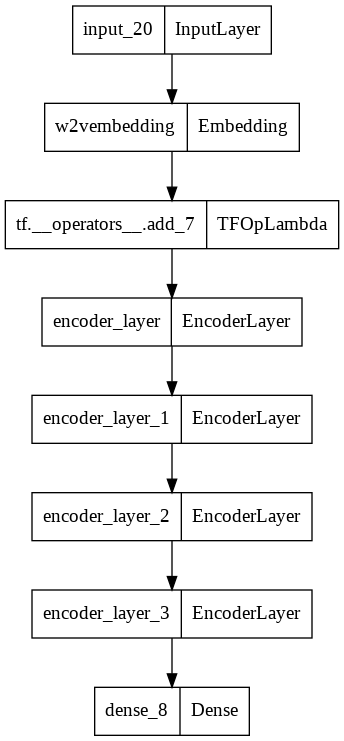

In [253]:
tf.keras.utils.plot_model(model_2, expand_nested=True, to_file='transformer_model.png')

In [254]:
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True, verbose=1)
history_2 = model_2.fit(train_data, validation_data=val_data, epochs=100, callbacks=es)

Epoch 1/100
22/22 [==============================] - 23s 890ms/step - loss: 0.7117 - accuracy: 0.8847 - val_loss: 0.3883 - val_accuracy: 0.9296
Epoch 2/100
22/22 [==============================] - 19s 861ms/step - loss: 0.3747 - accuracy: 0.9274 - val_loss: 0.3333 - val_accuracy: 0.9307
Epoch 3/100
22/22 [==============================] - 19s 862ms/step - loss: 0.3273 - accuracy: 0.9320 - val_loss: 0.2881 - val_accuracy: 0.9359
Epoch 4/100
22/22 [==============================] - 19s 860ms/step - loss: 0.3207 - accuracy: 0.9322 - val_loss: 0.3313 - val_accuracy: 0.9270
Epoch 5/100
22/22 [==============================] - 19s 862ms/step - loss: 0.3189 - accuracy: 0.9309 - val_loss: 0.2723 - val_accuracy: 0.9394
Epoch 6/100
22/22 [==============================] - 19s 862ms/step - loss: 0.2616 - accuracy: 0.9397 - val_loss: 0.2316 - val_accuracy: 0.9441
Epoch 7/100
22/22 [==============================] - 19s 862ms/step - loss: 0.2310 - accuracy: 0.9446 - val_loss: 0.2200 - val_accuracy:

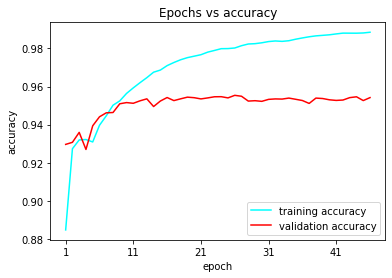

In [257]:
n_epochs = len(history_2.history['accuracy'])
plt.plot(range(1, n_epochs + 1), history_2.history['accuracy'],color='cyan', label='training accuracy')
plt.plot(range(1, n_epochs + 1), history_2.history['val_accuracy'],color='red', label='validation accuracy')
plt.legend(loc='best')
plt.xticks(range(1, n_epochs+1, 10))
plt.title("Epochs vs accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

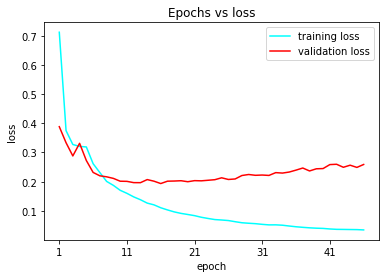

In [258]:
plt.plot(range(1, n_epochs + 1), history_2.history['loss'],color='cyan', label='training loss')
plt.plot(range(1, n_epochs + 1), history_2.history['val_loss'],color='red', label='validation loss')
plt.legend(loc='best')
plt.xticks(range(1, n_epochs+1, 10))
plt.title("Epochs vs loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [259]:
loss3, accuracy3 = model_2.evaluate(val_data)
print(f"\n\nModel with bidirectional lstm and lstm model is giving: \naccuracy: {accuracy3:.3f}\nloss: {loss3:.3f}")

6/6 [==============================] - 2s 270ms/step - loss: 0.2075 - accuracy: 0.9554


Model with bidirectional lstm and lstm model is giving: 
accuracy: 0.955
loss: 0.208


In [260]:
#making one sample from validatoin_data
x, y = next(iter(val_data.take(1)))
sample_x, sample_true_y = x[0], y[0]
print(f"Size of 1 sample from validation data is (x and y): {sample_x.shape, sample_true_y.shape}")

Size of 1 sample from validation data is (x and y): (TensorShape([795]), TensorShape([795, 63]))


In [261]:
pred_y = model_2.predict(np.expand_dims(sample_x, 0))[0]

In [263]:
#true ner tags
print_senttags(sample_x, sample_true_y)

sample token to word(padded tokens are skipped) with there corresponding tag (except for 'O' tag): 




'et[B-Citation] al.[I-Citation] ([I-Citation] 1996[I-Citation] )[I-Citation] and giri[B-Citation] chakrabarti[I-Citation] ([I-Citation] 2013[I-Citation] ):[I-Citation] the cooling rate is ‚àùœÅ[B-Formula] 2[I-Formula] t[I-Formula] Œ≤[I-Formula] , where Œ≤[B-Formula] >[I-Formula] 0[I-Formula] is the cooling index. for Œ≤[B-Formula] =[I-Formula] 0.5,[I-Formula] the process is bremsstrahlung. in order to ensure the formation of a cold[B-Model] keplerian[I-Model] disc,[I-Model] we must use higher Œ≤ in order for the cooling time-scale to be reduced compared with the infall time-scale. thus we increase cooling gradually inside the would-be keplerian[B-Model] component. when the region with keplerian[B-Model] distribution[I-Model] becomes optically thick, the index is raised to 0.6 as used in earlier simulations. this saves the prohibitive time required for monte[B-Model] carlo[I-Model] simulations,[I-Model] in order that normal bremsstrahlung radiation may be emitted as blackbody radiation 

In [264]:
# predicted ner tags
print_senttags(sample_x, pred_y)

sample token to word(padded tokens are skipped) with there corresponding tag (except for 'O' tag): 




'et[I-Citation] al.[I-Citation] ( 1996[I-Citation] ) and giri[B-Citation] chakrabarti[B-Model] ( 2013[I-Citation] ): the cooling rate is ‚àùœÅ 2 t[B-Formula] Œ≤[B-Formula] , where Œ≤[B-Formula] >[I-Formula] 0[I-Formula] is the cooling index. for Œ≤[B-Formula] =[I-Formula] 0.5,[I-Formula] the process is bremsstrahlung.[I-Formula] in order to ensure the formation of a cold keplerian[B-Model] disc, we must use higher Œ≤ in order for the cooling time-scale to be reduced compared with the infall time-scale. thus we increase cooling gradually inside the would-be[I-Model] keplerian[B-Model] component. when the region with keplerian[B-Model] distribution becomes optically thick, the index is raised to 0.6 as used in earlier simulations. this saves the prohibitive time required for monte[B-Model] carlo[I-Model] simulations, in order that normal bremsstrahlung radiation may be emitted as blackbody radiation in the optically thick region. giri[B-Citation] et[I-Citation] al.[I-Citation] ( 2015[I-C

We can see above that the transformer model outperforms every model we have used above. We can add more layers and run it for more epochs, to get even better results then this.

## 4. Finding the best model and inference.

In [267]:
losses = [loss1, loss2, loss3]
accuracies = [accuracy1, accuracy2, accuracy3]
models = ['vanila 2 stack lstm', 'bidirectional lstm (word2vec embedding)', 'Transformers (word2vec embedding)']
results_df = pd.DataFrame(zip(models, losses, accuracies), columns=['model', 'validaion loss', 'validation accuracy'])

In [268]:
results_df.style.background_gradient(cmap='gist_gray_r')

Iinference: We tried all the three models, but as we can see above that the transformers perform the best. One possible case for this could be because self attention block, not just it pays attention to the surronding context words like in word 2 vec or uses the last hidden state. 
It infacts looks at the whole sentances, much more like cnn for language models. Thus it has bigger receptive field and embbeds information of every word in a sentance's relations to the specific word and then creates an embedding of it, in order to predict the ner tag.